In [2]:
from train_model import *

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
models = {
    # '0213_MLP_env_1x1': 'MLP_1x1',#_weighted_loss', 
    # '0223_mlp_env_5x5': 'MLP_5x5',#_weighted_loss', 
    # '0226_mlp_env_16x16': 'MLP_16x16',#_weighted_loss',
    # '0226_CNN_env_16x16': 'CNN_16x16',#_weighted_loss',
    # '0223_CNN_env_32x32': 'CNN_32x32',#_weighted_loss',

    # '0227_mlp_env_1x1_an_loss': 'MLP_1x1',#_an_loss',
    # '0227_env5_mlp_an_loss': 'MLP_5x5',#_an_loss',
    # '0228_env16_mlp_an_loss': 'MLP_16x16',#_an_loss'


    '0226_resnet_sat_32x32_notpretrained': 'resnet_notpre_32x32_wl', 
    '0226_CNN_sat_32x32': 'cnn_32x32_wl',
    '0229_sat128_weighted_loss_not_pretrained': 'resnet_notpre_128x128_wl',
    '0223_resnet_sat_128x128_lr1e-3': 'resnet_pretrained_128x128_wl',
    '0229_sat128_cnn_an_loss': 'cnn_128x128_wl',
    '0301_resnet_sat_32x32_anloss_notpretrained': 'resnet_notpre_32x32_an',
    '0221_resnet_sat_128x128_an_full_loss': 'restnet_pretrained_128x128_an',
    '0221_resnet_sat_128x128_not_pretrained': 'resnet_notpre_128x128_an',

    # '0213_MLP_env_1x1': 'env1_mlp_wl',
    # '0223_resnet_sat_128x128_lr1e-3': 'sat128_resnet_pretrained_wl',
    # '0219_MultiScale_env_1_sat_128x128': 'multi_env1_mlp_sat128_resnet_pretrained_wl',
    # '0227_mlp_env_1x1_an_loss': 'env1_mlp_an',
    # '0221_resnet_sat_128x128_not_pretrained': 'sat128_resnet_not_pretrained_an',
    # '0226_mutli_mlp_env_1x1_resnet_sat_128x128_not_pretrained': 'multi_env1_mlp_sat128_resnet_not_pretrained_an',
    # '0229_sat128_weighted_loss_not_pretrained': 'sat128_resnet_not_pretrained_wl',
    # '0227_multi_mlp_env1_resnet_sat128_not_pretrained_weighted_loss': 'multi_env1_mlp_sat128_resnet_not_pretrained_wl',
    # '0221_resnet_sat_128x128_an_full_loss': 'sat128_resnet_pretrained_an'
}
checkpoint = 'best_val_auc' #'last

auc_df = pd.concat([
    pd.read_csv(f"models/{k}/{checkpoint}_species_auc.csv").rename(columns={"auc": v}).set_index(['species','n_occ']) for k, v in models.items()
], axis=1)

auc_df

,,resnet_notpre_32x32_wl,cnn_32x32_wl,resnet_notpre_128x128_wl,resnet_pretrained_128x128_wl,cnn_128x128_wl,resnet_notpre_32x32_an,restnet_pretrained_128x128_an,resnet_notpre_128x128_an
species,n_occ,,,,,,,,
1,2261,0.737099,0.935171,0.872181,0.571890,0.898812,0.965837,0.780856,0.862990
5,4529,0.653979,0.607364,0.652873,0.322237,0.579419,0.704501,0.554899,0.588449
10,2162,0.975353,0.944975,0.955980,0.795318,0.945271,0.944814,0.922373,0.951433
11,4508,0.695851,0.647604,0.659507,0.495555,0.636887,0.758671,0.719308,0.580618
24,4539,0.662207,0.660052,0.720464,0.575963,0.739039,0.665149,0.740445,0.717153
...,...,...,...,...,...,...,...,...,...
10028,204,0.976821,0.983008,0.985026,0.949832,0.982156,0.975297,0.954539,0.969917
10031,20,0.985075,0.875756,0.931289,0.924029,0.945139,0.872798,0.959661,0.961947
10035,110,0.521886,0.541524,0.451874,0.614129,0.496303,0.467445,0.511907,0.466123


In [71]:
auc_df.max(axis=1).mean()

0.8530249521500533

In [72]:
auc_df.max(axis=1).reset_index()[auc_df.reset_index()['n_occ'] <= 50].mean(axis=0)

species    5147.997863
n_occ        16.260684
0             0.913717
dtype: float64

In [15]:
auc_df.mean(axis=0)

env1_mlp_wl                                       0.792410
sat128_resnet_pretrained_wl                       0.680865
multi_env1_mlp_sat128_resnet_pretrained_wl        0.787133
env1_mlp_an                                       0.784933
sat128_resnet_not_pretrained_an                   0.793626
multi_env1_mlp_sat128_resnet_not_pretrained_an    0.828731
sat128_resnet_not_pretrained_wl                   0.794818
multi_env1_mlp_sat128_resnet_not_pretrained_wl    0.815319
sat128_resnet_pretrained_an                       0.799538
dtype: float64

In [12]:
auc_df.reset_index()[auc_df.reset_index()['n_occ'] <= 50].mean(axis=0)

species                                           5147.997863
n_occ                                               16.260684
env1_mlp_wl                                          0.853487
sat128_resnet_pretrained_wl                          0.716696
multi_env1_mlp_sat128_resnet_pretrained_wl           0.833100
env1_mlp_an                                          0.833601
sat128_resnet_not_pretrained_an                      0.849371
multi_env1_mlp_sat128_resnet_not_pretrained_an       0.877885
sat128_resnet_not_pretrained_wl                      0.843151
multi_env1_mlp_sat128_resnet_not_pretrained_wl       0.859563
dtype: float64

In [77]:
auc_df['delta_resnet_notpre_wl_128_32'] = auc_df['resnet_notpre_128x128_wl'] - auc_df['resnet_notpre_32x32_wl']
auc_df['delta_cnn_wl_128_32'] = auc_df['cnn_128x128_wl'] - auc_df['cnn_32x32_wl']
auc_df['delta_resnet_notpre_an_128_32'] = auc_df['resnet_notpre_128x128_an'] - auc_df['resnet_notpre_32x32_an']
auc_df = auc_df.reset_index()
auc_df 

# f = list(models.values())[0]
# for m in list(models.values())[1:]:
#     auc_df[f"delta_{m}_{ref}"] = auc_df[m]-auc_df[ref]
# auc_df = auc_df.reset_index()
# auc_df

,species,n_occ,resnet_notpre_32x32_wl,cnn_32x32_wl,resnet_notpre_128x128_wl,cnn_128x128_wl,resnet_notpre_32x32_an,resnet_notpre_128x128_an,delta_resnet_notpre_wl_128_32,delta_cnn_wl_128_32,delta_resnet_notpre_an_128_32
0,1,2261,0.737099,0.935171,0.872181,0.901816,0.965837,0.862990,0.135082,-0.033356,-0.102847
1,5,4529,0.653979,0.607364,0.652873,0.579231,0.704501,0.588449,-0.001106,-0.028133,-0.116052
2,10,2162,0.975353,0.944975,0.955980,0.945406,0.944814,0.951433,-0.019373,0.000431,0.006619
3,11,4508,0.695851,0.647604,0.659507,0.632344,0.758671,0.580618,-0.036344,-0.015260,-0.178053
4,24,4539,0.662207,0.660052,0.720464,0.739781,0.665149,0.717153,0.058256,0.079728,0.052004
...,...,...,...,...,...,...,...,...,...,...,...
2169,10028,204,0.976821,0.983008,0.985026,0.982560,0.975297,0.969917,0.008204,-0.000448,-0.005380
2170,10031,20,0.985075,0.875756,0.931289,0.945677,0.872798,0.961947,-0.053785,0.069921,0.089149
2171,10035,110,0.521886,0.541524,0.451874,0.495832,0.467445,0.466123,-0.070011,-0.045692,-0.001322
2172,10038,10,0.914347,0.844023,0.965981,0.825467,0.873067,0.818072,0.051634,-0.018556,-0.054995


In [78]:
auc_df['n_occ_cat'] = pd.cut(auc_df['n_occ'], [1, 50, 500, 3000, 4600]) #[1, 50, 500, 2000, 2500]
print(auc_df.groupby('n_occ_cat').count().species)

n_occ_cat
(1, 50]         422
(50, 500]       536
(500, 3000]     569
(3000, 4600]    601
Name: species, dtype: int64


In [79]:
auc_melt = pd.melt(auc_df.reset_index(), 
                  id_vars=['species','n_occ','n_occ_cat'], 
                  value_vars=[c for c in list(auc_df.columns) if 'delta' not in c and c not in ['species','n_occ','n_occ_cat']],
                  var_name='model', value_name='AUC')
auc_melt['patch_size'] = auc_melt['model'].apply(lambda x: x.split('_')[-2])
# auc_melt['loss'] = auc_melt['model'].apply(lambda x: x.split('_')[-1])
auc_melt['model_loss'] = auc_melt['model'].apply(lambda x: '_'.join(x.split('_')[:-2] + [x.split('_')[-1]]))
auc_melt

,species,n_occ,n_occ_cat,model,AUC,patch_size,model_loss
0,1,2261,"(500, 3000]",resnet_notpre_32x32_wl,0.737099,32x32,resnet_notpre_wl
1,5,4529,"(3000, 4600]",resnet_notpre_32x32_wl,0.653979,32x32,resnet_notpre_wl
2,10,2162,"(500, 3000]",resnet_notpre_32x32_wl,0.975353,32x32,resnet_notpre_wl
3,11,4508,"(3000, 4600]",resnet_notpre_32x32_wl,0.695851,32x32,resnet_notpre_wl
4,24,4539,"(3000, 4600]",resnet_notpre_32x32_wl,0.662207,32x32,resnet_notpre_wl
...,...,...,...,...,...,...,...
13039,10028,204,"(50, 500]",resnet_notpre_128x128_an,0.969917,128x128,resnet_notpre_an
13040,10031,20,"(1, 50]",resnet_notpre_128x128_an,0.961947,128x128,resnet_notpre_an
13041,10035,110,"(50, 500]",resnet_notpre_128x128_an,0.466123,128x128,resnet_notpre_an
13042,10038,10,"(1, 50]",resnet_notpre_128x128_an,0.818072,128x128,resnet_notpre_an


In [86]:
tmp = auc_melt.groupby(['species', 'model_loss']).AUC.max().reset_index().groupby('model_loss').AUC.mean()
tmp

model_loss
cnn_wl              0.819650
resnet_notpre_an    0.827754
resnet_notpre_wl    0.820726
Name: AUC, dtype: float64

In [95]:
delta_auc_melt = pd.melt(auc_df.reset_index(), 
                  id_vars=['species','n_occ','n_occ_cat'], 
                  value_vars=[c for c in list(auc_df.columns) if 'delta' in c and c not in ['species','n_occ','n_occ_cat']],
                  var_name='models', value_name='delta_AUC')
delta_auc_melt

,species,n_occ,n_occ_cat,models,delta_AUC
0,1,2261,"(500, 3000]",delta_resnet_notpre_wl_128_32,0.135082
1,5,4529,"(3000, 4600]",delta_resnet_notpre_wl_128_32,-0.001106
2,10,2162,"(500, 3000]",delta_resnet_notpre_wl_128_32,-0.019373
3,11,4508,"(3000, 4600]",delta_resnet_notpre_wl_128_32,-0.036344
4,24,4539,"(3000, 4600]",delta_resnet_notpre_wl_128_32,0.058256
...,...,...,...,...,...
6517,10028,204,"(50, 500]",delta_resnet_notpre_an_128_32,-0.005380
6518,10031,20,"(1, 50]",delta_resnet_notpre_an_128_32,0.089149
6519,10035,110,"(50, 500]",delta_resnet_notpre_an_128_32,-0.001322
6520,10038,10,"(1, 50]",delta_resnet_notpre_an_128_32,-0.054995


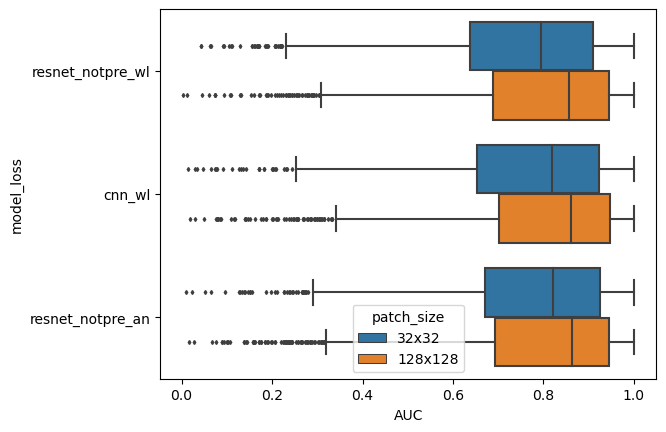

In [92]:
g = sns.boxplot(auc_melt, y='model_loss', hue='patch_size', x='AUC', fliersize=2)

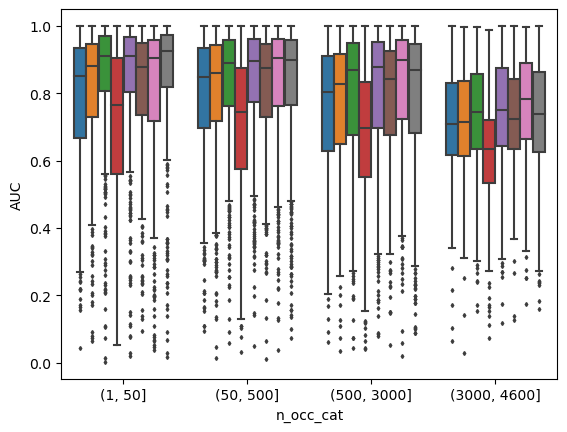

In [58]:
sns.boxplot(auc_melt, hue='model', x='n_occ_cat', y='AUC', fliersize=2)
plt.legend([],[], frameon=False)

<AxesSubplot: xlabel='n_occ_cat', ylabel='delta_AUC'>

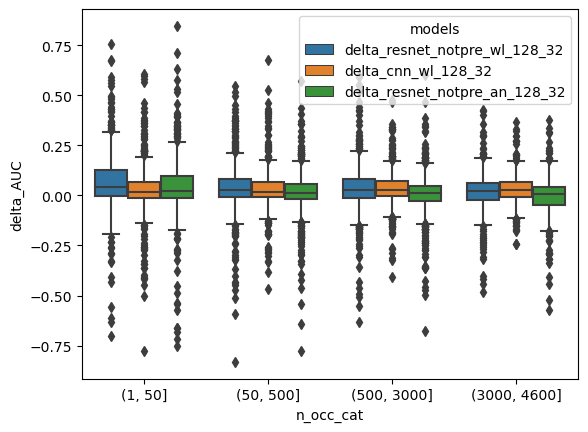

In [100]:
sns.boxplot(delta_auc_melt, x='n_occ_cat', hue='models', y='delta_AUC')#, dodge = True, s=3)

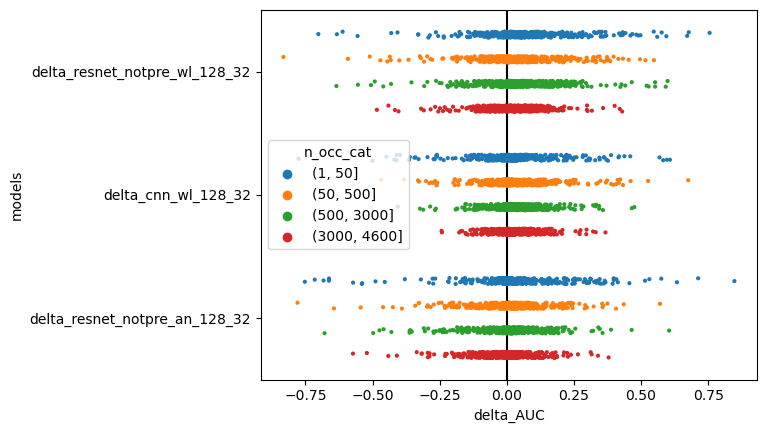

In [103]:
g = sns.stripplot(delta_auc_melt, hue='n_occ_cat', x='delta_AUC', y='models', dodge = True, s=3)
g.axvline(0, color='k')



In [4]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}")
    
train_data, val_data, model, optimizer, multires = setup_model(
    model_setup, train_occ_path, random_bg_path, val_occ_path,
    n_max_low_occ, embed_shape, learning_rate, seed
)
model = model.to(dev)

DEVICE: cuda

Making patch providers with size=1x1, flatten=True for covariates:
	 - data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/full_data/EnvironmentalRasters/Soilgrids/
	 - data/full_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making patch providers with size=128x128, flatten=False for covariates:
	 - data/full_data/SatelliteImages/

Making dataset for training occurrences
nb items = 2856818
nb species = 2174
nb of species with less than 50 occurrences = 468
input shape: [(41,), (4, 128, 128)]

Making dataset for validation occurrences
nb items = 7438
nb species = 2174
nb of species with less than 50 occurrences = 1822


In [5]:
print(f"\nLoading model from checkpoint {run_name}")
checkpoint = torch.load(f"models/{run_name}/{checkpoint_to_load}.pth")
print(checkpoint['epoch'], checkpoint['val_auc'])
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 


Loading model from checkpoint 0219_MultiScale_env_1_sat_128x128
24 0.7871325572527568


In [8]:
ll_weights = model.fc.weight.data.detach().cpu().numpy()

In [13]:
ll_weights.shape

(2174, 1024)

In [25]:
w = ll_weights[0,:]
w = np.abs(w)
w = w / w.sum()
w[:512].sum()

0.48805836

In [27]:
w[512:].sum()

0.51194173

In [56]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index().rename(columns={'index':'species'})
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df

,species,n_occ,auc
0,1,1125,0.329298
1,5,2243,0.431015
2,10,1085,0.885215
3,11,2284,0.713295
4,24,2315,0.521655
...,...,...,...
2134,10028,93,0.829455
2135,10031,9,0.943122
2136,10035,60,0.563982
2137,10038,6,0.959796


In [58]:
df.auc.median()

0.638885149788367

In [10]:
model.eval()
labels_list, y_pred_list = [], []

for inputs, _, labels in tqdm(val_loader):    
    if multires:
        inputsA = inputs[0].to(torch.float32).to(dev)
        inputsB = inputs[1].to(torch.float32).to(dev)
        y_pred = torch.sigmoid(model(inputsA, inputsB))
    else:
        inputs = inputs[0].to(torch.float32).to(dev)
        y_pred = torch.sigmoid(model(inputs))
    
    y_pred_list.append(y_pred.cpu().detach().numpy())
    labels_list.append(labels)

labels = np.concatenate(labels_list)
y_pred = np.concatenate(y_pred_list)

100%|██████████| 59/59 [00:46<00:00,  1.27it/s]


In [11]:
auc = roc_auc_score(labels, y_pred)
print('AUC = ', auc)

AUC =  0.7956252848286665


In [15]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index().rename(columns={'index':'species'})
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df

,species,n_occ,auc
0,1,2261,0.958821
1,5,4529,0.687385
2,10,2162,0.940468
3,11,4508,0.666231
4,24,4539,0.829301
...,...,...,...
2169,10028,204,0.935665
2170,10031,20,0.062122
2171,10035,110,0.537498
2172,10038,10,0.989781


In [17]:
df.to_csv(f"models/{run_name}/last_auc_per_species.csv", index=False)

In [18]:
print(df.groupby('num_presences_cat').count())

                   index  n_occ  auc
num_presences_cat                   
(1, 50]              575    575  575
(50, 250]            469    469  469
(250, 1000]          459    459  459
(1000, 1250]         502    502  502


In [20]:
def compute_f1(labels, pred):
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    f1 = tp / (tp + ((fp+fn)/2))
    return f1

In [29]:
f1_scores = {}
for thresh in np.arange(0.05, 1, 0.05):
    try:
        y_pred_bin = binarize(y_pred, threshold=thresh)
        f1_list = [compute_f1(labels[i,:], y_pred_bin[i,:]) for i in range(labels.shape[0])]
        f1_mean = np.mean(f1_list)
        print(thresh, '.... f1 = ', f1_mean)
        f1_scores[thresh] = f1_mean
    except:
        f1_scores[thresh] = np.nan 
        
max_f1 = np.nanmax(list(f1_scores.values()))
threshold = [k for k,v in f1_scores.items() if v == max_f1][0]


0.05 .... f1 =  0.010707814469055004
0.1 .... f1 =  0.01111779857855658
0.15000000000000002 .... f1 =  0.01207326461291827
0.2 .... f1 =  0.013238900564891642
0.25 .... f1 =  0.014407193227791666
0.3 .... f1 =  0.015592485476829043
0.35000000000000003 .... f1 =  0.016749635184104918
0.4 .... f1 =  0.017870066897042187
0.45 .... f1 =  0.01895140510300799
0.5 .... f1 =  0.019844175832729904
0.55 .... f1 =  0.020916620992410654
0.6000000000000001 .... f1 =  0.020605439638756697
0.6500000000000001 .... f1 =  0.01604780727739449
0.7000000000000001 .... f1 =  0.010592128302088511
0.7500000000000001 .... f1 =  0.009572105460100249
0.8 .... f1 =  0.009368207974469347
0.8500000000000001 .... f1 =  0.007342346804093446
0.9000000000000001 .... f1 =  0.0036175935365548896


IndexError: list index out of range

In [37]:
max_f1 = np.nanmax(list(f1_scores.values()))
threshold = [k for k,v in f1_scores.items() if v == max_f1][0]

Text(0.5, 0.98, '0208_MLP_env_1_weighted_loss_1')

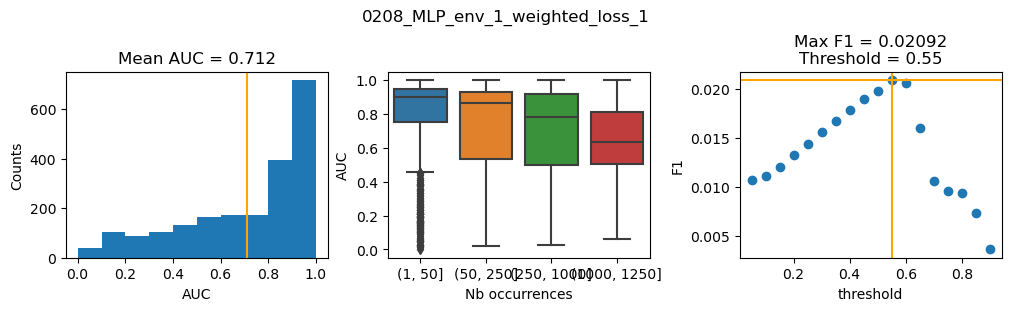

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout='constrained', figsize=(10,3))

mean1 = df.auc.mean()
ax1.hist(df.auc)
ax1.axvline(mean1, color='orange')
ax1.set(xlabel='AUC', ylabel='Counts', title=f"Mean AUC = {mean1:.3f}")

sns.boxplot(data=df, x="num_presences_cat", y="auc", ax=ax2)
ax2.set(xlabel='Nb occurrences', ylabel='AUC')

ax3.scatter(x=list(f1_scores.keys()), y=list(f1_scores.values()))
ax3.axhline(y=max_f1, color='orange')
ax3.axvline(x=threshold, color='orange')
ax3.set(xlabel='threshold', ylabel='F1', title=f"Max F1 = {max_f1:.5f}\nThreshold = {threshold}")

fig.suptitle(run_name)



In [57]:
mean_weights = pd.DataFrame({
    'bioclim': weights[:,:512].mean(axis=1), 'sat': weights[:,512:].mean(axis=1)
}).sort_values(['bioclim','sat'])

In [61]:
mean_weights.values.shape

(2088, 2)

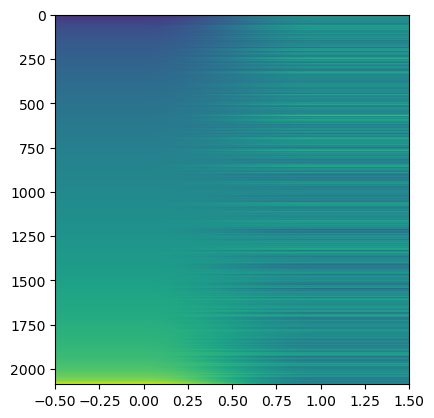

In [67]:
plt.imshow(mean_weights.values, aspect=0.001)

In [39]:
roc_auc_score(labels, y_pred)

0.7856477944925715

In [40]:
roc_auc_score(labels[:, low_occ_species_idx], y_pred[:, low_occ_species_idx])

0.8021208924074779

In [183]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index()
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df

,index,n_occ,auc
0,1,2261,0.942233
1,5,4529,0.641626
2,10,2162,0.938100
3,11,4508,0.668044
4,24,4539,0.808725
...,...,...,...
2169,10028,204,0.913114
2170,10031,20,0.799381
2171,10035,110,0.467925
2172,10038,10,0.944332


<AxesSubplot: xlabel='n_occ', ylabel='auc'>

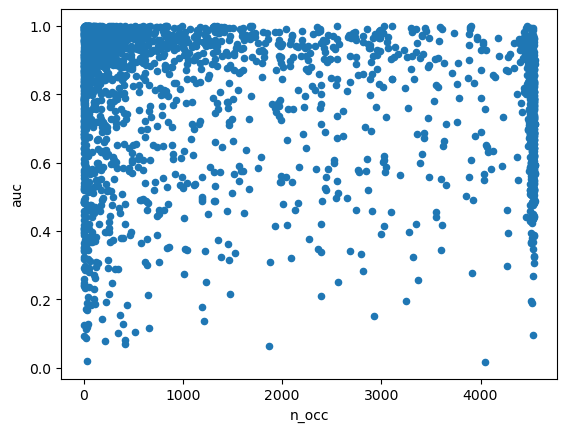

In [184]:
df.plot.scatter(x='n_occ', y='auc')

array([[<AxesSubplot: title={'center': 'auc'}>]], dtype=object)

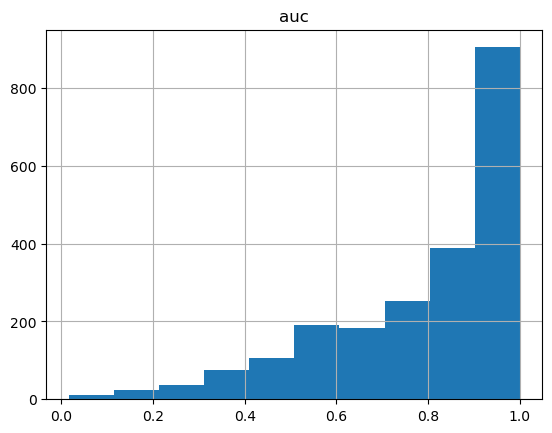

In [185]:
df.hist('auc')

In [132]:
f1_scores = {}

In [133]:
def compute_f1(labels, pred):
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    f1 = tp / (tp + ((fp+fn)/2))
    return f1

In [148]:
np.arange(0.025, 1, 0.025)

array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
       0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
       0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
       0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  ,
       0.925, 0.95 , 0.975])

In [141]:
for thresh in [0.725, 0.775, 0.825, 0.875]:#[0.1,0.2,0.3,0.4,0.5,0.6]:
    y_pred_bin = binarize(y_pred, threshold=thresh)
    f1_list = [compute_f1(labels[i,:], y_pred_bin[i,:]) for i in range(labels.shape[0])]
    f1_mean = np.mean(f1_list)
    print(thresh, '.... f1 = ', f1_mean)
    f1_scores[thresh] = f1_mean

0.725 .... f1 =  0.06117215804106441
0.775 .... f1 =  0.06264313190626879
0.825 .... f1 =  0.06173608953075929
0.875 .... f1 =  0.05883165026162659


In [142]:
dict(sorted(f1_scores.items()))

{0.1: 0.02710992021944885,
 0.2: 0.03364692441686345,
 0.3: 0.03942517650257939,
 0.4: 0.04484486907101754,
 0.5: 0.05034539790447907,
 0.6: 0.056212310325247414,
 0.7: 0.06004252688166328,
 0.725: 0.06117215804106441,
 0.75: 0.06217998207848221,
 0.775: 0.06264313190626879,
 0.8: 0.06277095937546352,
 0.825: 0.06173608953075929,
 0.85: 0.06166061019067241,
 0.875: 0.05883165026162659,
 0.9: 0.05529068820707533}

In [176]:
max_f1 = np.max(list(f1_scores.values()))
threshold = [k for k,v in f1_scores.items() if v == max_f1][0]
print('threshold', threshold)
print('max f1', max_f1)

threshold 0.8
max f1 0.06277095937546352


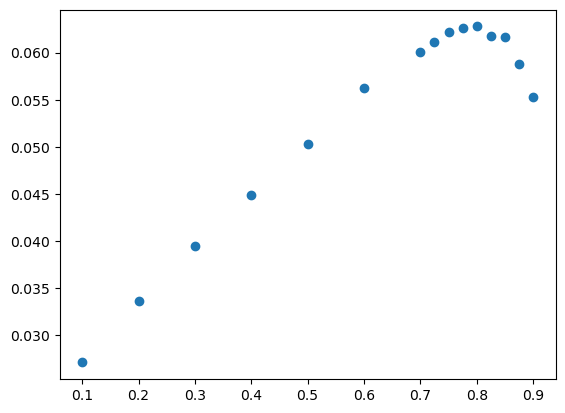

In [143]:
plt.scatter(x=f1_scores.keys(), y=f1_scores.values())

In [197]:
f1_scores

{0.1: 0.02710992021944885,
 0.2: 0.03364692441686345,
 0.3: 0.03942517650257939,
 0.4: 0.04484486907101754,
 0.5: 0.05034539790447907,
 0.6: 0.056212310325247414,
 0.7: 0.06004252688166328,
 0.8: 0.06277095937546352,
 0.9: 0.05529068820707533,
 0.75: 0.06217998207848221,
 0.85: 0.06166061019067241,
 0.725: 0.06117215804106441,
 0.775: 0.06264313190626879,
 0.825: 0.06173608953075929,
 0.875: 0.05883165026162659}

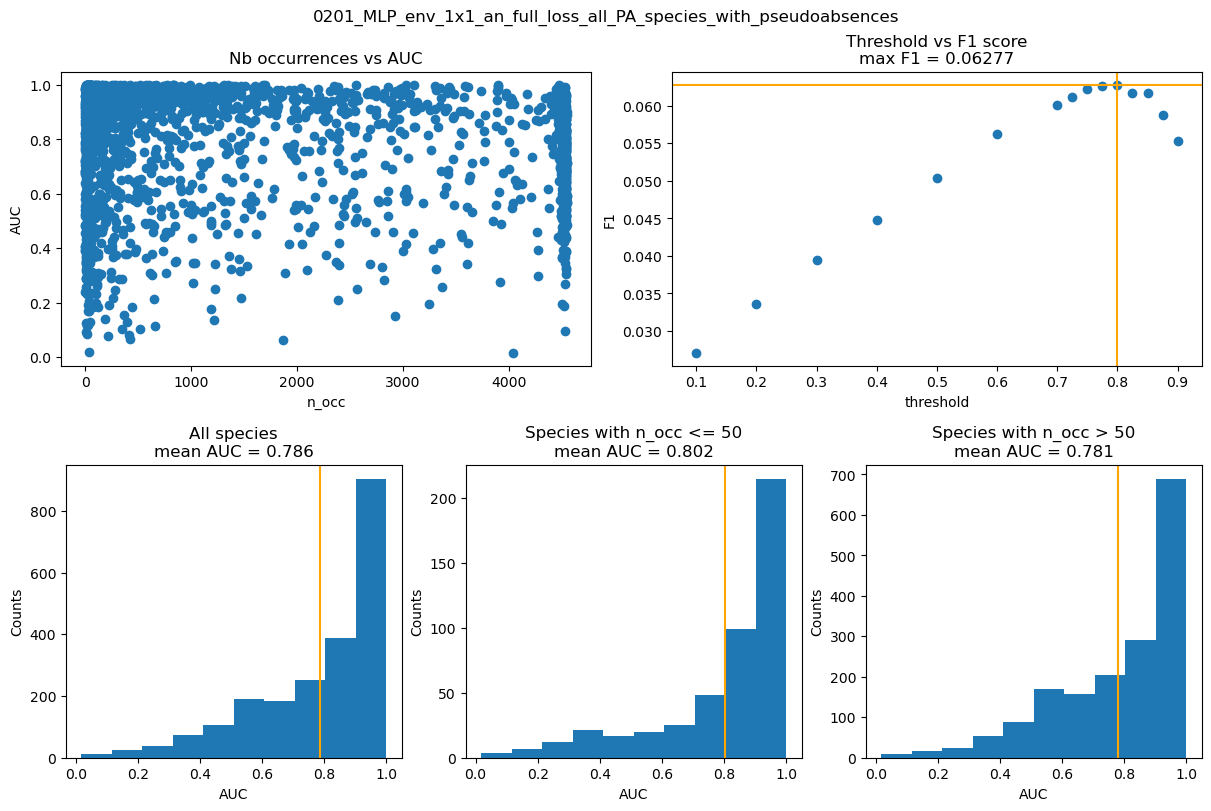

In [243]:
fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(2, 1)

ax1, ax2 = subfigs[0].subplots(1, 2)
ax1.scatter(x=df.n_occ, y=df.auc)
ax1.set(xlabel='n_occ', ylabel='AUC', title='Nb occurrences vs AUC')

ax2.scatter(x=list(f1_scores.keys()), y=list(f1_scores.values()))
ax2.axhline(y=max_f1, color='orange')
ax2.axvline(x=threshold, color='orange')
ax2.set(xlabel='threshold', ylabel='F1', title=f"Threshold vs F1 score\nmax F1 = {max_f1:.5f}")

ax1, ax2, ax3 = subfigs[1].subplots(1, 3)
ax1.hist(df.auc)
mean1 = df.auc.mean()
ax1.axvline(mean1, color='orange')
ax1.set(xlabel='AUC', ylabel='Counts', title=f"All species\nmean AUC = {mean1:.3f}")

ax2.hist(df[df['n_occ'] <= n_max_low_occ].auc)
mean2 = df[df['n_occ'] <= n_max_low_occ].auc.mean()
ax2.axvline(mean2, color='orange')
ax2.set(xlabel='AUC', ylabel='Counts', title=f"Species with n_occ <= 50\nmean AUC = {mean2:.3f}")

ax3.hist(df[df['n_occ'] > n_max_low_occ].auc)
mean3 = df[df['n_occ'] > n_max_low_occ].auc.mean()
ax3.axvline(mean3, color='orange')
ax3.set(xlabel='AUC', ylabel='Counts', title=f"Species with n_occ > 50\nmean AUC = {mean3:.3f}")

fig.suptitle(run_name)
plt.savefig('test.png')